In [ ]:
import tensorflow
import nltk
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
!mkdir -p /content/drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteIM3C6O/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteIM3C6O/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteIM3C6O/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_test = tfds.load('imdb_reviews', split='test', shuffle_files=True)

In [ ]:
df = tfds.as_dataframe(ds)
df_test = tfds.as_dataframe(ds_test)

In [ ]:
df.to_csv('/content/drive/MyDrive/DPL302m/imdb_train.csv')
df_test.to_csv('/content/drive/MyDrive/DPL302m/imdb_test.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DPL302m/imdb_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/DPL302m/imdb_test.csv')

In [ ]:
df.head()

,Unnamed: 0,label,text
0,0,0,"b""This was an absolutely terrible movie. Don't..."
1,1,0,b'I have been known to fall asleep during film...
2,2,0,b'Mann photographs the Alberta Rocky Mountains...
3,3,1,b'This is the kind of film for a snowy Sunday ...
4,4,1,"b'As others have mentioned, all the women that..."


In [ ]:
df_test.head()

,Unnamed: 0,label,text
0,0,1,"b""There are films that make careers. For Georg..."
1,1,1,"b""A blackly comic tale of a down-trodden pries..."
2,2,0,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee..."
3,3,0,b'Poor Shirley MacLaine tries hard to lend som...
4,4,1,b'As a former Erasmus student I enjoyed this f...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  25000 non-null  int64 
 1   label       25000 non-null  int64 
 2   text        25000 non-null  object
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  25000 non-null  int64 
 1   label       25000 non-null  int64 
 2   text        25000 non-null  object
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [ ]:
print(df.label.value_counts())
print(df_test.label.value_counts())

0    12500
1    12500
Name: label, dtype: int64
1    12500
0    12500
Name: label, dtype: int64


In [ ]:
train_data = df.drop(columns=['Unnamed: 0'])
test_data = df_test.drop(columns=['Unnamed: 0'])
train_data['text'] = df['text'].str[2:-1]
test_data['text'] = df_test['text'].str[2:-1]
print(train_data.head())
print(test_data.head())

   label                                               text
0      0  This was an absolutely terrible movie. Don't b...
1      0  I have been known to fall asleep during films,...
2      0  Mann photographs the Alberta Rocky Mountains i...
3      1  This is the kind of film for a snowy Sunday af...
4      1  As others have mentioned, all the women that g...
   label                                               text
0      1  There are films that make careers. For George ...
1      1  A blackly comic tale of a down-trodden priest,...
2      0  Scary Movie 1-4, Epic Movie, Date Movie, Meet ...
3      0  Poor Shirley MacLaine tries hard to lend some ...
4      1  As a former Erasmus student I enjoyed this fil...


In [ ]:
data = [train_data, test_data]
data = pd.concat(data)
data.head(10)

,label,text
0,0,This was an absolutely terrible movie. Don't b...
1,0,"I have been known to fall asleep during films,..."
2,0,Mann photographs the Alberta Rocky Mountains i...
3,1,This is the kind of film for a snowy Sunday af...
4,1,"As others have mentioned, all the women that g..."
5,1,This is a film which should be seen by anybody...
6,0,"Okay, you have:<br /><br />Penelope Keith as M..."
7,0,The film is based on a genuine 1950s novel.<br...
8,0,I really love the sexy action and sci-fi films...
9,0,"Sure, this one isn\'t really a blockbuster, no..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50000 non-null  int64 
 1   text    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
english_stops = stopwords.words('english')

In [ ]:
def preprocess_review(df):
    x_data = df['text']
    x_data = x_data.replace({'<.*?>': ''}, regex = True)
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])
    x_data = x_data.apply(lambda review: [w.lower() for w in review])

    y_data = np.array(df['label'])

    return x_data, y_data
data_train, label_train = preprocess_review(data)

In [ ]:
print(data_train.head())
print(label_train)

0    [this, absolutely, terrible, movie, don, lured...
1    [i, known, fall, asleep, films, usually, due, ...
2    [mann, photographs, alberta, rocky, mountains,...
3    [this, kind, film, snowy, sunday, afternoon, r...
4    [as, others, mentioned, women, go, nude, film,...
Name: text, dtype: object
[0 0 0 ... 0 1 1]


In [ ]:
reviewLen = int(np.ceil(np.mean([len(i) for i in data_train])))
reviewLen

131

In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(data_train)
data_train = token.texts_to_sequences(data_train)

data_train = pad_sequences(data_train, maxlen=reviewLen, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', data_train, '\n')
print(total_words)

Encoded X Train
 [[    8   328   288 ...     0     0     0]
 [    1   460   680 ...     0     0     0]
 [ 4421  6624 26599 ...     0     0     0]
 ...
 [  743 27196     3 ...     0     0     0]
 [    7   531     1 ...     0     0     0]
 [  110    25  2263 ...     0     0     0]] 

101627


In [ ]:
data_train[1]

array([    1,   460,   680,  2314,    35,   536,   593,  2097,    89,
         492,    14,  1339,  2261,  3755, 43742,  4045,    83,    99,
        4503,     1,  1411,  2314,     4,  1827,     2,    42,   888,
        1797,  1248,   469,   259,    89,   371,   487,  1692,  3621,
           1,   893,     1,   109,   958,    85,     4,   199,  2166,
         174,   371,   487, 31268,   118,    65,  4809,   141,   233,
           1,  2098,   286,     4,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train, label_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

(40000, 131)
(40000,)


In [ ]:
EMBED_DIM = 50
model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = reviewLen))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 131, 50)           5081350   
                                                                 
 lstm (LSTM)                 (None, 131, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 131, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,304,711
Trainable params: 5,304,711
Non-

In [ ]:
history = model.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
1250/1250 [==============================] - 116s 85ms/step - loss: 0.6831 - accuracy: 0.5536
Epoch 2/15
1250/1250 [==============================] - 31s 25ms/step - loss: 0.6539 - accuracy: 0.6025
Epoch 3/15
1250/1250 [==============================] - 23s 19ms/step - loss: 0.6023 - accuracy: 0.6776
Epoch 4/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3691 - accuracy: 0.8472
Epoch 5/15
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2155 - accuracy: 0.9227
Epoch 6/15
1250/1250 [==============================] - 20s 16ms/step - loss: 0.1487 - accuracy: 0.9507
Epoch 7/15
1250/1250 [==============================] - 18s 15ms/step - loss: 0.0968 - accuracy: 0.9698
Epoch 8/15
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0639 - accuracy: 0.9810
Epoch 9/15
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0427 - accuracy: 0.9884
Epoch 10/15
1250/1250 [==============================] - 17s 14

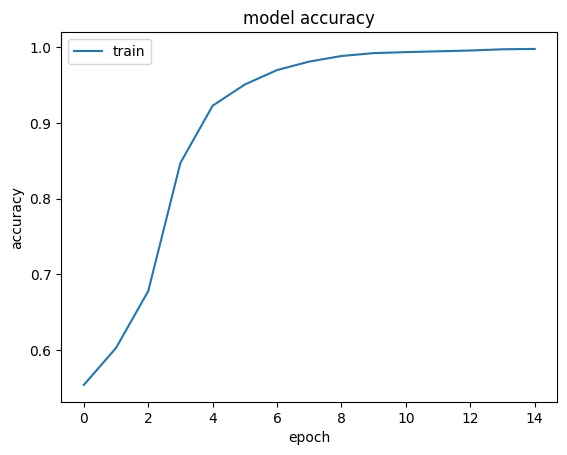

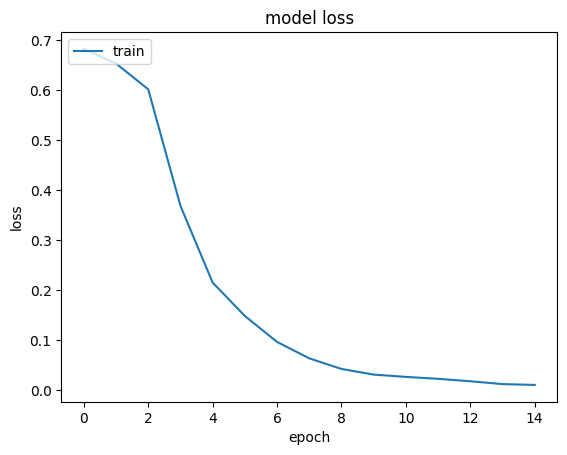

In [ ]:
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 6ms/step - loss: 0.7399 - accuracy: 0.8549


[0.7399067282676697, 0.8549000024795532]

In [ ]:
review = str(input('Movie Review: '))
review_list = ['The score of the movie is stunning.', 'The first scene of the movie grabbed me at the first glance and took me to another world.',
                "I don't like the way how the director decided to shoot this scene on that castle.", 'I found the girl on the movie very hot and breath-taking.',
                'Nothing was typical about this. Everything was beautifully done in this movie, the story, the flow, the scenario, everything. I highly recommend it for mystery lovers, for anyone who wants to watch a good movie!']

Movie Review: Nothing was typical about this. Everything was beautifully done in this movie, the story, the flow, the scenario, everything. I highly recommend it for mystery lovers, for anyone who wants to watch a good movie!


In [ ]:
def clean(review):
  regex = re.compile(r'[^a-zA-Z\s]')
  review = regex.sub('', review)
  words = review.split(' ')
  filtered = [w for w in words if w not in english_stops]
  filtered = ' '.join(filtered)
  filtered = [filtered.lower()]
  return filtered

review = clean(review)
print(review)

['nothing typical everything beautifully done movie story flow scenario everything i highly recommend mystery lovers anyone wants watch good movie']


In [ ]:
tokenize_words = token.texts_to_sequences(review)
tokenize_words = pad_sequences(tokenize_words, maxlen=reviewLen, padding='post', truncating='post')
print(tokenize_words)

[[  77  691  174 1187  130    3   13 2709 2626  174    1  453  286  693
  1729  154  399   33    9    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]


In [ ]:
result = model.predict(tokenize_words)

1/1 [==============================] - 1s 679ms/step


In [ ]:
if result >= 0.7:
    print('positive')
else:
    print('negative')

positive


### Thành viên:

1. Bùi Mộc Quế Anh: Tìm kiếm dữ liệu, tìm hiểu và implement mô hình, làm slide, thuyết trình.
2. Lê Văn Huỳnh: Thiết kế slide, Đánh giá kết quả, demo, thuyết trình.